In [55]:
path = r'C:\Users\user\Desktop\NLP'

In [56]:
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

In [57]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from nltk.stem.snowball import EnglishStemmer

'''Using NLTK would have been interesting because it has some good pre-process functions like Stemming/Lemming. But in the case
of spam detection, Upper/Lower case are important because some SPAM are written in CAPSLOCK.'''

'Using NLTK would have been interesting because it has some good pre-process functions like Stemming/Lemming. But in the case\nof spam detection, Upper/Lower case are important because some SPAM are written in CAPSLOCK.'

In [58]:
import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [38]:
from functions import plot_history, stemmed_words

In [39]:
with open('XY.data', 'rb') as f:
    sentences_train, sentences_test, y_train, y_test = pickle.load(f)
    
sentences_train.shape, sentences_test.shape

((4179,), (1393,))

# **Word Embedding Model**

### Process the data
* **Note**: Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.
* With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.

In [40]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # Removing special characters as well as punctuation
                      lower=False,                                    # Keep the distinct. bc it is important in Spam detection
                      split=' ',                                      # "Words are set of char splitted by a space"
                      char_level=False)                               # If True, every character will be treated as a token
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[1])
print(X_train[1])

Hi darlin i cantdo anythingtomorrow as myparents aretaking me outfor a meal. when are u free? Katexxx
[140, 8, 86, 11, 4, 48, 23, 10, 91]


In [41]:
for word in ['Hi', 'hi', 'Hello', 'hello']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

Hi: 140
hi: 396
Hello: 336
hello: 2142


### Padding
* One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros.

In [42]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 150

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0,:])
print(len(X_train[0]))

[990   3  24 718 894   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
150


In [51]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

def def_flat_NN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(input_dim = vocab_size, 
                      output_dim = embedding_dim, 
                      input_length = maxlen)(inputs)
    layer = Flatten()(layer)
    layer = Dense(10, activation = 'relu')(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = def_flat_NN()
model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
              loss='binary_crossentropy',  # Binary Classification SPAM/HAM
              metrics=['accuracy'])        # Metrics we want to maximize
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 150, 50)           476700    
_________________________________________________________________
flatten_5 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                75010     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 551,721
Trainable params: 551,721
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_split = 0.2,
                    batch_size=100)

model.save('model.WE')

Train on 3343 samples, validate on 836 samples
Epoch 1/10
3343/3343 [==============================] - 1s 165us/step - loss: 0.4069 - accuracy: 0.8445 - val_loss: 0.3507 - val_accuracy: 0.8612
Epoch 2/10
3343/3343 [==============================] - 0s 104us/step - loss: 0.2724 - accuracy: 0.8663 - val_loss: 0.2153 - val_accuracy: 0.8612
Epoch 3/10
3343/3343 [==============================] - 0s 103us/step - loss: 0.1679 - accuracy: 0.9040 - val_loss: 0.1681 - val_accuracy: 0.9569
Epoch 4/10
3343/3343 [==============================] - 0s 99us/step - loss: 0.1397 - accuracy: 0.9713 - val_loss: 0.1526 - val_accuracy: 0.9653
Epoch 5/10
3343/3343 [==============================] - 0s 103us/step - loss: 0.1256 - accuracy: 0.9791 - val_loss: 0.1441 - val_accuracy: 0.9701
Epoch 6/10
3343/3343 [==============================] - 0s 103us/step - loss: 0.1157 - accuracy: 0.9844 - val_loss: 0.1396 - val_accuracy: 0.9749
Epoch 7/10
3343/3343 [==============================] - 0s 103us/step - loss: 

In [53]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9935
Testing Accuracy:  0.9720


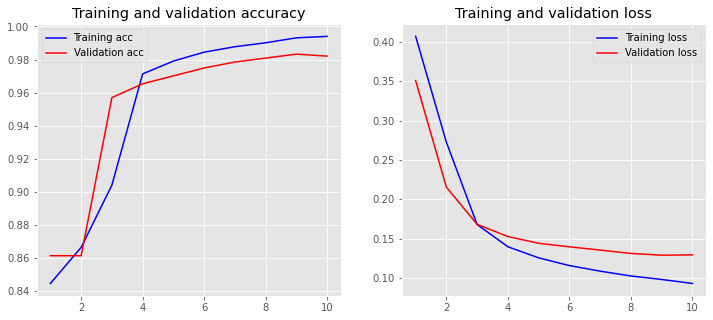

In [54]:
plot_history(history)

# **Testing with our Emails**

In [47]:
modelWE = keras.models.load_model('model.WE')

In [48]:
test = ["Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!"]

test_tok  = tokenizer.texts_to_sequences(test)
test_tok = pad_sequences(test_tok, padding = 'post', maxlen=maxlen)
sentiment = modelWE.predict(test_tok,batch_size=1,verbose = 2)[0]

if sentiment > 0.5:
    label = "SPAM"
else:
    label = "HAM"

print(label, sentiment, test) 

SPAM [0.62228096] ['Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!']


# **LSTM - Long Short Term Memory**

In [50]:


maxlen = 150
embedding_dim = 50

def def_LSTM():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(input_dim = 1000, output_dim = embedding_dim, input_length = maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = def_LSTM()
model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
              loss='binary_crossentropy',  # Binary Classification SPAM/HAM
              metrics=['accuracy'])        # Metrics we want to maximize
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 150, 50)           50000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               16640     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257 

In [63]:
history = model.fit(np.array(X_train), np.array(y_train),
          epochs=10,
          verbose=True,
          validation_split = 0.2,
          batch_size=128,
          callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)])

model.save('model.WE_LSTM')

Train on 3343 samples, validate on 836 samples
Epoch 1/10
3343/3343 [==============================] - 0s 123us/step - loss: 0.0813 - accuracy: 0.9970 - val_loss: 0.0965 - val_accuracy: 0.9892
Epoch 2/10
3343/3343 [==============================] - 0s 83us/step - loss: 0.0790 - accuracy: 0.9973 - val_loss: 0.0940 - val_accuracy: 0.9904
Epoch 3/10
3343/3343 [==============================] - 0s 81us/step - loss: 0.0781 - accuracy: 0.9982 - val_loss: 0.0938 - val_accuracy: 0.9892
Epoch 4/10
3343/3343 [==============================] - 0s 82us/step - loss: 0.0762 - accuracy: 0.9985 - val_loss: 0.0935 - val_accuracy: 0.9856
Epoch 5/10
3343/3343 [==============================] - 0s 82us/step - loss: 0.0733 - accuracy: 0.9982 - val_loss: 0.0910 - val_accuracy: 0.9892
Epoch 6/10
3343/3343 [==============================] - 0s 82us/step - loss: 0.0716 - accuracy: 0.9988 - val_loss: 0.0914 - val_accuracy: 0.9892


In [65]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9969
Testing Accuracy:  0.9727


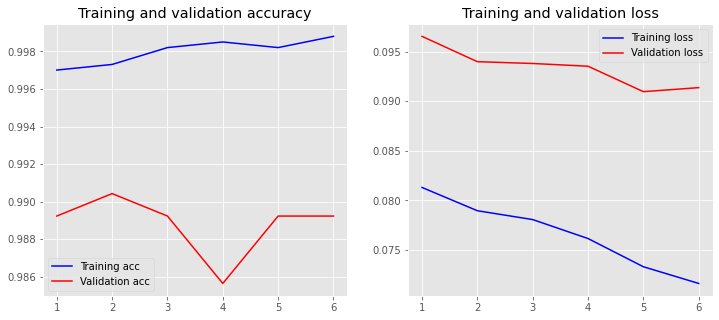

In [66]:
plot_history(history)

# **Testing with our Emails**

In [67]:
modelWE_LSTM = keras.models.load_model('model.WE_LSTM')

In [68]:
test = ["Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!"]

test_tok  = tokenizer.texts_to_sequences(test)
test_tok = pad_sequences(test_tok, padding = 'post', maxlen=maxlen)
sentiment = modelWE_LSTM.predict(test_tok,batch_size=1,verbose = 2)[0]

if sentiment > 0.5:
    label = "SPAM"
else:
    label = "HAM"

print(label, sentiment, test) 

SPAM [0.6084835] ['Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!']
